# Week 6 : Titanic Top 4% with Ensemble Modeling

Kaggle link : https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## Loading Packages And Datsets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Counter 패키지는 어떤 단어가 주어졌을 때, 단어에 포함된 각 알파멧의 글자 수를 세어주는 툴
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook',  palette = 'deep')

In [2]:
train = pd.read_csv('data/titanic_train.csv')
test = pd.read_csv('data/titanic_test.csv')
IDtest = test['PassengerId']

<b> Outlier Detection

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        # 이상치 탐색
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col) # append

    outlier_indices = Counter(outlier_indices)
    multiple_outlier = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outlier
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

items()함수를 사용하면 딕셔너리에 있는 키와 값들의 쌍을 얻을 수 있습니다. 

append와 extend의 차이 : https://wangkisa.tistory.com/41

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


이상치는 예측에 많은 영향을 주기 때문에 삭제하는 것이 좋다.

In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<b> Joining Train sets and Test sets

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train, test],axis = 0).reset_index(drop = True)
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Check the Missing Value

In [7]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Cabin, Age의 결측치가 많다. (Survived의 결측치는 test셋의 결측치이다.)

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature Analysis
### 1. Numercial Values

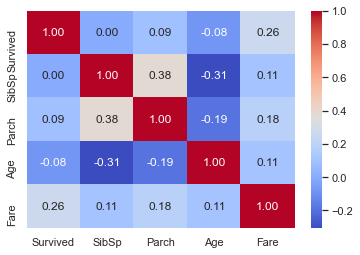

In [10]:
g= sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

Survived와 유의미한 상관관계를 가진 변수는 Fare 변수이다. 하지만 다른 변수들 또한 유용할 수 있기 때문에 좀 더 탐색해보도록 한다.

<b> SibSp

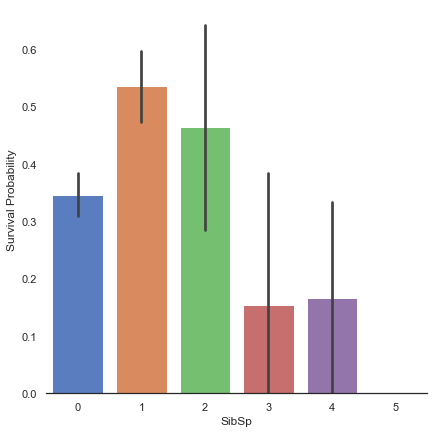

In [11]:
g= sns.catplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

위 그래프를 보면 SibSp가 높은 승객들보다는 SibSp이 적은 0,1,2의 사람들이 더욱 많이 살아남았다는 것을 알 수 있다.

<b> Parch

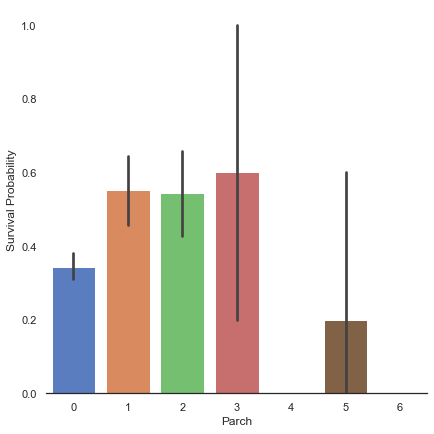

In [12]:
g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

적은 수의 가족들(1,2)가 싱글보다는 살아남은 확률이 높았고, 대가족(5,6)인 경우는 살아남을 확률이 낮았다.

하지만 중간 규모의 가족들 (3)은 std가 매우 높기 때문에 분석에 유의해야 한다!

<b> Age

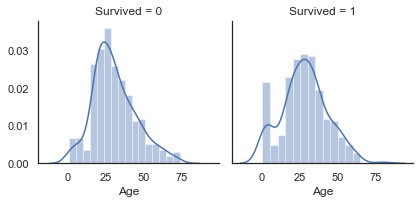

In [13]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

두 분포 모두 정규분포보다는 한 쪽으로 조금 치우친 분포를 띈다.

생존자의 경우와 사망자의 경우의 분포가 다르다.

생존자의 경우, 어린 아이들이 많이 살았남았다는 것을 확인 할 수 있다. 반면 60-80세의 사람들은 많이 사망하였다.

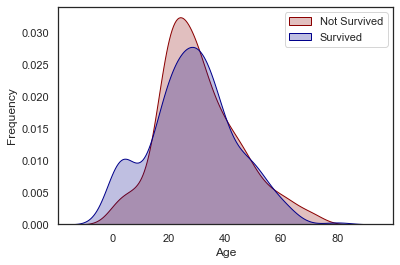

In [14]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'darkred', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Darkblue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

<b> Fare

In [15]:
dataset['Fare'].isnull().sum()

1

In [16]:
# 결측값 대체
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

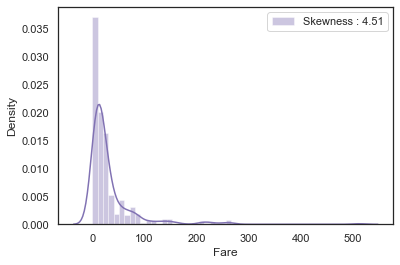

In [17]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f' % (dataset['Fare'].skew()))
g = g.legend(loc = 'best')

Fare의 분포는 매우 skew 되어있으므로, 스케일링 필요해보인다. 

위와 같은 분포를 띄는 경우에는 log 함수를 통해 정규분포에 근사할 수 있다.

In [18]:
# log 함수를 통해 정규근사화
dataset['Fare'] = dataset['Fare'].map(lambda x : np.log1p(x))

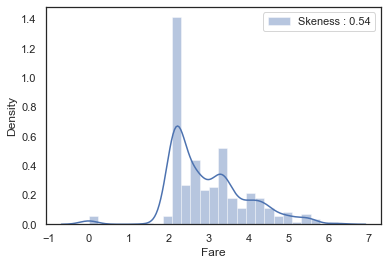

In [19]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skeness : %.2f' % (dataset['Fare'].skew()))
g = g.legend(loc = 'best')

### 2. Categorical Values

<b> Sex

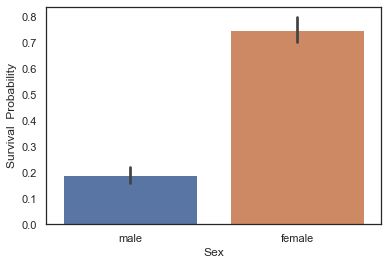

In [20]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival  Probability')

In [21]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.747573
male      0.190559
Name: Survived, dtype: float64

여성이 남성보다 살아남을 확률이 훨씬 높다. 

그러므로 Sex라는 변수는 예측에 매우 중요한 변수이다.

<b> PClass

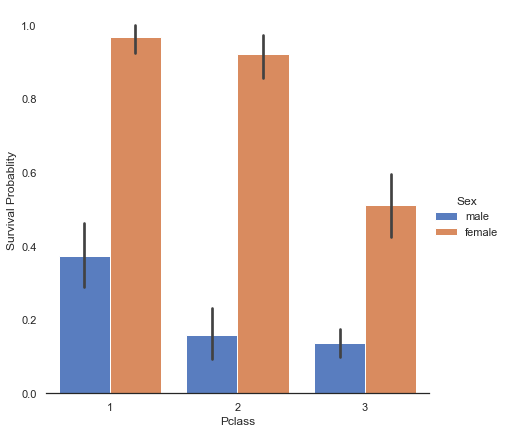

In [22]:
g = sns.catplot(x = 'Pclass', y = 'Survived', data = train, hue = 'Sex', kind = 'bar', height = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probablity')

좌석에 따라 다른 생존율이 다르며 ,가장 좋은 좌석인 1등급의 승객들이 2,3등급의 승객들보다 많이 살아남았다.

<b> Embarked

In [23]:
dataset['Embarked'].isnull().sum()

2

In [24]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [25]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

최빈값으로 채워줌.

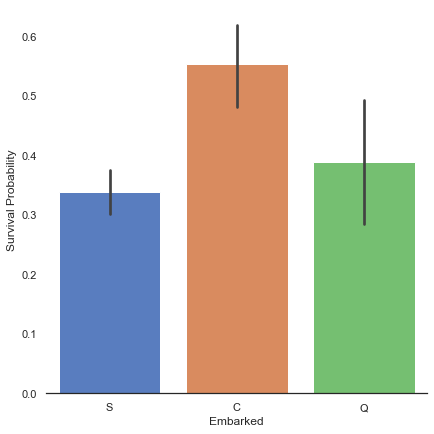

In [26]:
g = sns.catplot(x = 'Embarked', y = 'Survived', data = train, height = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

C(셰르부르옥트빌(프랑스 북부 지역))에서 탑승한 승객들의 생존율이 높은 것으로 보인다.

- 가설 : C(셰르부르옥트빌)에서 탑승한 승객들이 1등급에 승선하였고, Q(퀸즈타운)과 S(사우스햄튼)의 승객들은 2, 3등급에 승선하는 비율이 높았기 때문이다.

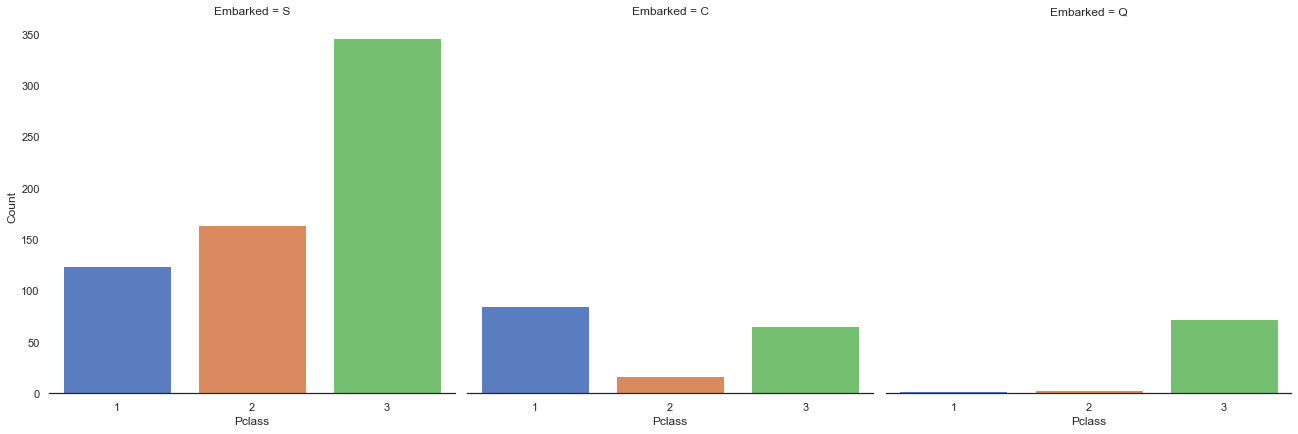

In [27]:
g = sns.catplot('Pclass', col = 'Embarked', data = train, height = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

분석 결과 가설에서 가정한 것처럼 C(셰르부르옥트빌)에서 온 승객들은 1등급 좌석에 승선하는 비율이 높았다.

S(사우스햄튼)에서 온 승객들은 3등급 좌석에 승선하는 비율이 매우 높았다.

### Filling Missing Value

<b> Age

Age는 256개의 Missing value가 존재했고, Age에 따라 생존율이 달랐기 때문에 이를 분석에 이용한다. 그러기 위해서 Missing value를 대체해줘야 한다.

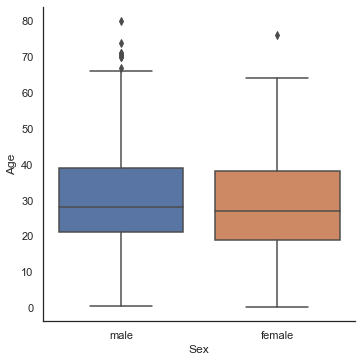

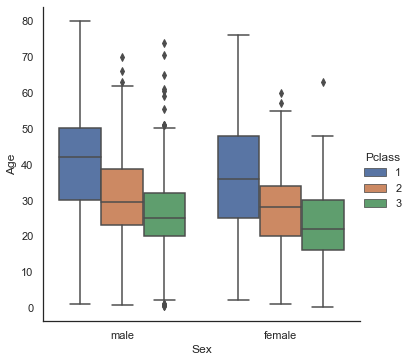

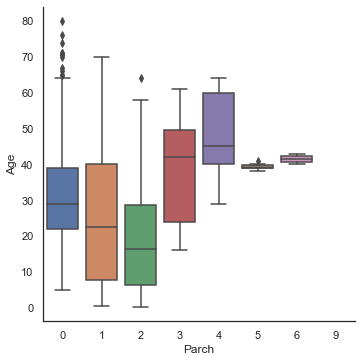

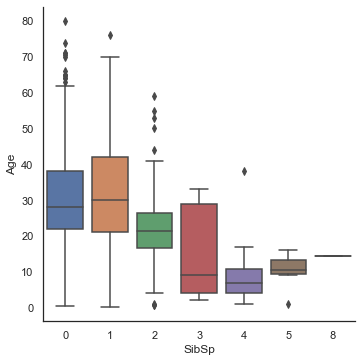

In [28]:
g = sns.catplot(y = 'Age', x = 'Sex',  data = dataset, kind = 'box')
g = sns.catplot(y = 'Age', x = 'Sex', hue = 'Pclass', data = dataset, kind = 'box')
g = sns.catplot(y = 'Age', x = 'Parch', data = dataset, kind= 'box')
g = sns.catplot(y = 'Age', x = 'SibSp', data = dataset, kind = 'box')

- Sex에 따른 분포는 별 차이가 없어보이므로, Sex 변수는 Age를 예측하는데 좋은 변수는 아니다.

- Pclass에서 1등급의 승객들은 다른 등급의 승객들보다 높은 연령대를 보인다.

- Parch(부모/자식)이 많을수록 연령대가 높다.

- SibSp(형제 자매/배우자)가 많을수록 연령대가 낮다.

In [29]:
# mapping
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

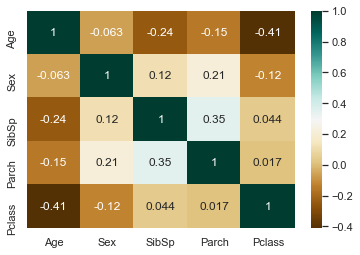

In [30]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

- Age는 Pclass, Parch, SibSp와 음의 상관관계를 가짐.

In [31]:
# Impute the Missing Value

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & 
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) & 
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

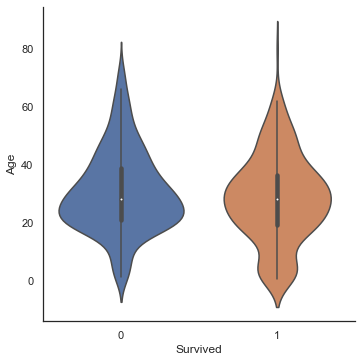

In [32]:
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

## Feature Engineering

<b> Name/ Title

In [33]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name 변수는 Title(Mrs, Mrs etc)에 대한 정보를 가지고 있다.

탈출시, Title에 따라 우선순위가 결정될 것이다.

In [34]:
# Get Title from Name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]

In [35]:
# [i.split(',')[1] for i in dataset['Name']]
# [i.split(',')[1].split('.')[0] for i in dataset['Name']]
#[i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]

strip() 공백을 제거하는 함수

In [36]:
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

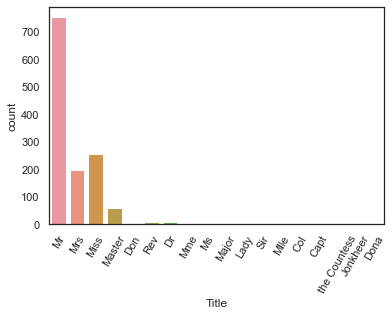

In [37]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 60)

총 17개의 Title이 있고, Mr, Mrs, Miss, Master를 제외하면 대부분의 Title은 매우 적다. 그러므로 4개의 변수로 범주화 할 것이다.

In [38]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master' : 0, 'Miss' : 1, 'Ms' : 1, 'Mme' : 1, 'Mlle' : 1, 'Mrs' : 1, 'Mr' : 2, 'Rare' : 3})
dataset['Title'] = dataset['Title'].astype(int)

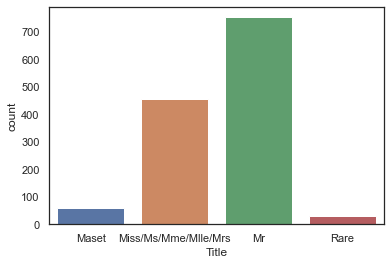

In [39]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Maset', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

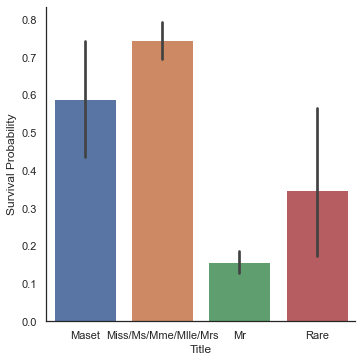

In [40]:
g = sns.catplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Maset', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

Rare title을 갖고 있는 승객이 Mr보다 생존율이 높다.

In [41]:
dataset.drop('Name', axis = 1, inplace =True)

<b> Family Size

In [42]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1 # it's me

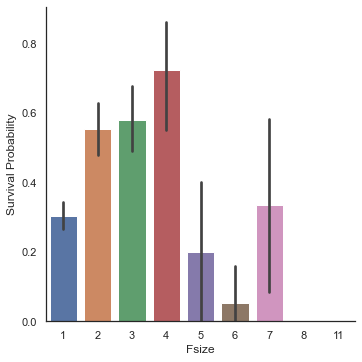

In [43]:
g = sns.catplot(x = 'Fsize', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

Family  size에 따라 생존율이 다르므로 Family size는 예측에 유용한 변수로 보인다.

대가족일 경우, 낮은 생존율을 보인다. 보다 좋은 분석을 위해 4개로 범주화 할 것이다.

In [44]:
# Mapping
dataset['Single'] = dataset['Fsize'].map(lambda x : 1 if x == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda x :1 if x == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda x :1 if 3 <= x <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda x : 1 if x >= 5 else 0)

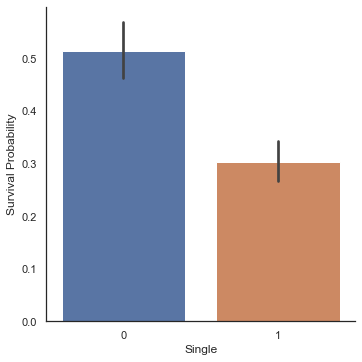

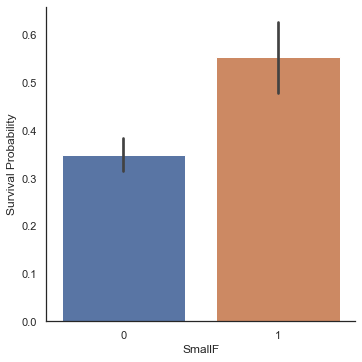

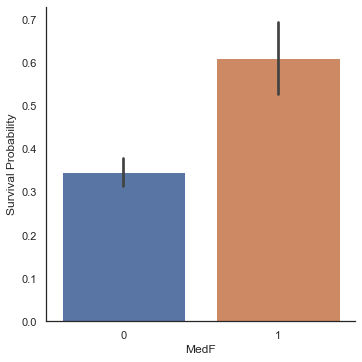

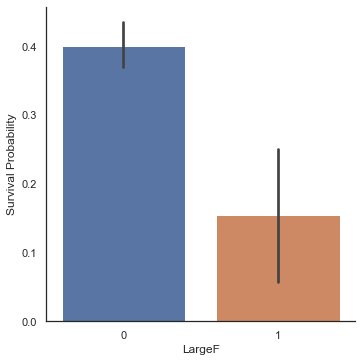

In [45]:
famsize = ['Single', 'SmallF', 'MedF', 'LargeF']

for col in famsize:
    g = sns.catplot(x = col, y = 'Survived', data = dataset, kind = 'bar')
    g = g.set_ylabels('Survival Probability')

### Dummification

In [46]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,2.110213,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.280593,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.188856,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.990834,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.202765,NaN,...,0,0,0,0,0,1,0,0,0,1


<b> Cabin

In [47]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [48]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].isnull().sum()

1007

In [50]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [51]:
# Cabin이 NaN이라면, X
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])
dataset['Cabin'].head()

0    X
1    C
2    X
3    C
4    X
Name: Cabin, dtype: object

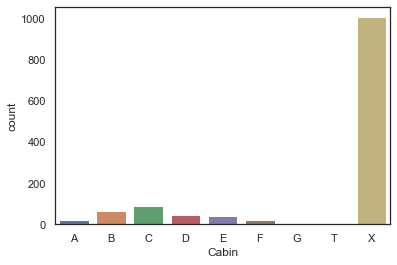

In [52]:
g = sns.countplot(dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G','T', 'X'])

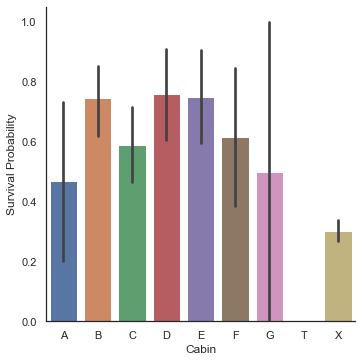

In [53]:
g = sns.catplot(x = 'Cabin', y = 'Survived', data = dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G','T', 'X'])
g = g.set_ylabels('Survival Probability')

Cabin을 가진 사람의 수가 적기 때문에 std가 매우 높다. 

따라서 특정 Cabin에 따라 생존율이 높다고는 확언할 수 없지만, Cabin이 없는(X) 승객보단 Cabin이 있는 승객들이 생존율이 높다.

In [54]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

<b> Ticket

In [55]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [56]:
Ticket = []

for i in list(dataset['Ticket']):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [57]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix= 'T')

In [58]:
# Dummificaiton Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'PC')

In [59]:
# Drop PassengerId
dataset.drop('PassengerId', axis = 1, inplace = True)

In [60]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,PC_1,PC_2,PC_3
0,0.0,0,22.0,1,0,2.110213,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.280593,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.188856,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.990834,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.202765,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Modeling

In [61]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop('Survived', axis = 1, inplace = True)

In [62]:
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)

### Simple Modeling

- SVC
- Decision Tree
- AdaBoost
- RandomForest
- Extra Trees
- Gradient Boosting
- Multiple layer perceptron (Neural Network)
- KNN
- Logistic Regression
- Linear Discriminant Analysis

In [63]:
kfold = StratifiedKFold(n_splits=10)

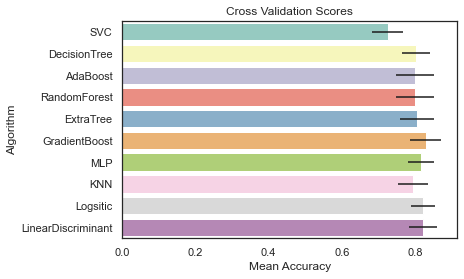

In [64]:
random_state = 2

classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv = kfold, n_jobs = 4))

cv_mean = []
cv_std = []

for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans' : cv_mean, 'CrossValerrors' : cv_std, 
                       'Algorithm' : ['SVC', 'DecisionTree', 'AdaBoost','RandomForest', 'ExtraTree', 'GradientBoost', 'MLP', 'KNN', 'Logsitic', 'LinearDiscriminant']})

g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette = 'Set3', orient = 'h', **{'xerr' : cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

### HyperParameter Tunning

In [65]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.9s finished


In [66]:
print('AdaBoost :', gsadaDTC.best_score_)

AdaBoost : 0.8241317671092953


In [67]:
# ExtraTree
ExtC = ExtraTreesClassifier()

ex_params_grid = {'max_depth' : [None],
                 'max_features' : [1,3, 10],
                 'min_samples_split' : [2,3,10],
                 'min_samples_leaf' : [1,3,10],
                 'bootstrap' : [False],
                 'n_estimators': [100,300],
                 'criterion' : ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_params_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
gsExtC.fit(X_train, y_train)
ExtC_best = gsExtC.best_estimator_

# Best score
print('Extra Tree :', gsExtC.best_score_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   53.7s finished


Extra Tree : 0.8297497446373849


In [68]:
# RandomForest
RFC = RandomForestClassifier()

rf_params_grid = {'max_depth' : [None], 
                 'max_features' : [1,3,10],
                 'min_samples_split' : [2,3,10],
                 'min_samples_leaf' : [1,3,10],
                 'bootstrap' : [False],
                 'n_estimators' : [100,300],
                 'criterion' : ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_params_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
gsRFC.fit(X_train, y_train)
RFC_best = gsRFC.best_estimator_

# Best score
print('Random Forest :', gsRFC.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.2s


Random Forest : 0.8308861082737489


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   54.3s finished


In [69]:
# Gradient Boosting

GBC = GradientBoostingClassifier()
gb_params_grid = {'loss' : ['deviance'],
                 'n_estimators' : [100,200,300],
                 'learning_rate' : [0.1, 0.05, 0.01],
                 'max_depth' : [4,8],
                 'min_samples_leaf' : [100,150],
                 'max_features' : [0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_params_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
gsGBC.fit(X_train, y_train)
GBC_best = gsGBC.best_estimator_

# Best Score
print('Gradient Boosting: ', gsGBC.best_score_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   30.7s finished


Gradient Boosting:  0.8274770173646578


### Plot Learning Rate

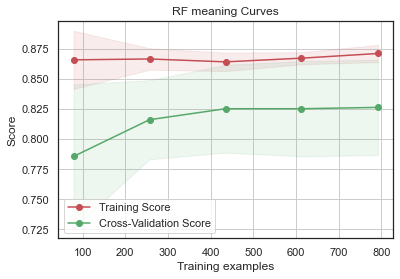

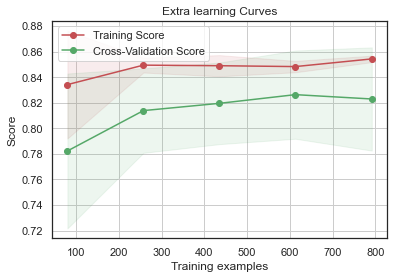

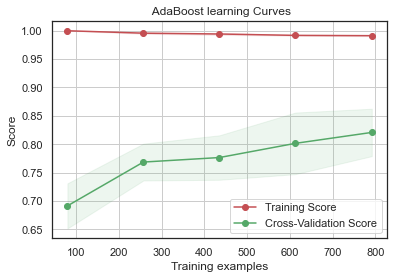

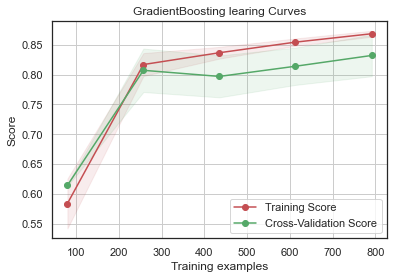

In [70]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis =1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean,'-o', color = 'r', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-Validation Score')
    plt.legend(loc = 'best')
    return plt
g = plot_learning_curve(gsRFC.best_estimator_, 'RF meaning Curves', X_train, y_train, cv = kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'Extra learning Curves', X_train, y_train, cv = kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, ' AdaBoost learning Curves', X_train, y_train, cv = kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learing Curves', X_train, y_train, cv = kfold)

Gradient Boosting과 AdaBoost는 오버피팅 되는 경향이 보인다.

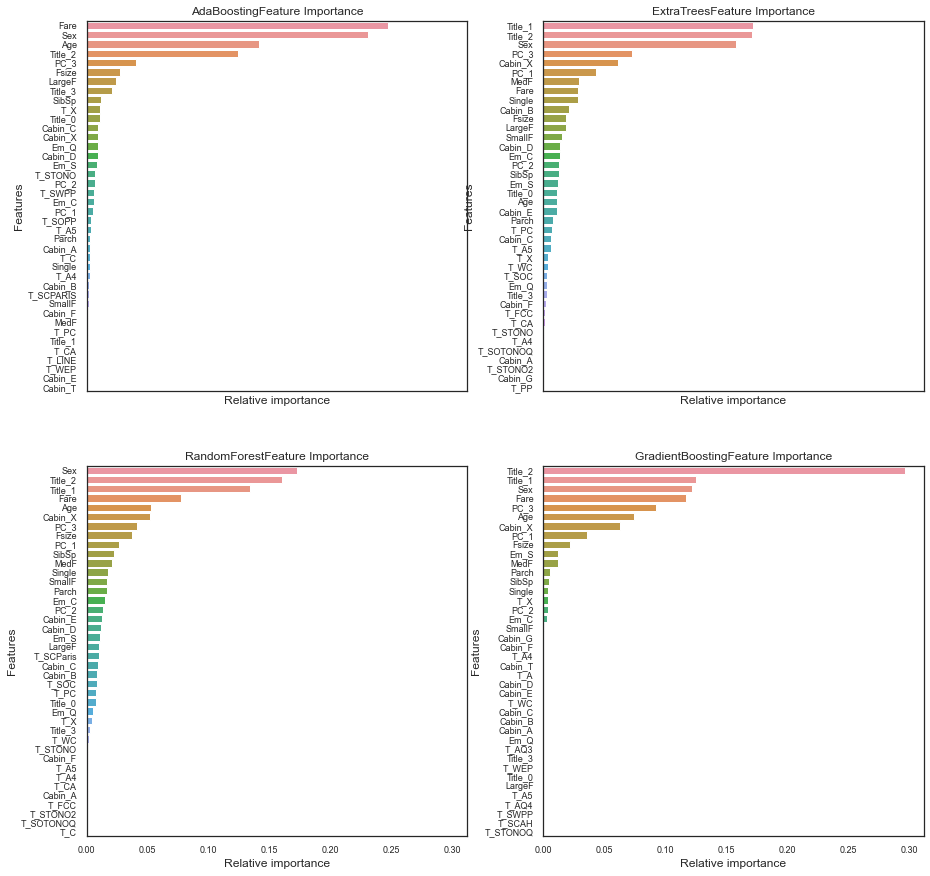

In [71]:
nrows = ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0

for row in range(nrows) :
    for col in range(ncols) :
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y = X_train.columns[indices][:40], x = classifier.feature_importances_[indices][:40], orient = 'h' , ax = axes[row][col])
        g.set_xlabel('Relative importance', fontsize = 12)
        g.set_ylabel('Features', fontsize = 12)
        g.tick_params(labelsize = 9)
        g.set_title(name + 'Feature Importance')
        nclassifier += 1

4개의 모델에서 가장 높은 feature importance를 보이는 변수들이 다르다.

하지만 Fare, Title_2, Age, Sex와 같은 변수들은 공통적으로 높은 Feature importance를 보인다.

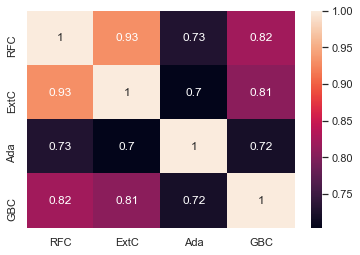

In [72]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name = 'RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name = 'ExtC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name = 'Ada')
test_Survived_GBC  = pd.Series(GBC_best.predict(test), name = 'GBC')

# 모든 Classifier의 결과를 병합
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC], axis = 1)

g = sns.heatmap(ensemble_results.corr(), annot = True)

AdaBoost를 제외한 나머지 Classifer들은 상당부분 비슷해보인다.

### Ensemble Modeling

In [73]:
voting = VotingClassifier(estimators  = [('rfc', RFC_best), ('extc', ExtC_best), ('adac', ada_best), ('gbc', GBC_best)], voting = 'soft', n_jobs = 4)
voting = voting.fit(X_train, y_train)

In [74]:
test_Survived = pd.Series(voting.predict(test), name = 'Survived')
results = pd.concat([IDtest, test_Survived], axis = 1)
results.to_csv('ensemble_python_voting.csv', index = False)